# Forward Volatility

This notebook will create a forward volatility strategy on the Nifty call options to generate profit from any mispricing of options in the market. 

1. [What is Forward Volatility](#intro)
2. [Time to Expiry](#expiry)
3. [Implied Volatility (IV)](#volatility)
4. [Forward Volatility](#fvolatility)
5. [Trading Signal](#signal)
6. [Calculate PnL](#PnL)

<a id='intro'></a>
## What is Forward Volatility?

Forward volatility represents the market's expectation of volatility **between two future dates**, typically between the expiration dates of two different option contracts. While implied volatility (IV) for a single option tells us how volatile the market expects the underlying asset to be up to a certain expiry, **forward volatility isolates the expected volatility during the interval between two expiries**.

Mathematically, forward volatility between $T_1$ and $T_2$ is given by:

$$
\sigma_{\text{fwd}}(T_1 \to T_2) = \sqrt{ \frac{ \sigma^2(T_2) \cdot T_2 - \sigma^2(T_1) \cdot T_1 }{ T_2 - T_1 } }
$$

where:
- $\sigma(T_1)$ and $\sigma(T_2)$ are the implied volatilities of the near and far-month options, respectively
- $T_1$ and $T_2$ are the time to expiry in **years**

In [ ]:
import mibian as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

<a id='import'></a>
## Import the Data

We import the CSV file containing the Nifty call options data. You can download this data from the last unit of this course '**Python Codes and Data**'.

In [ ]:
nifty_data = pd.read_csv('data_modules/Nifty.csv', index_col='date')
nifty_data.index = pd.to_datetime(nifty_data.index)
nifty_data.near_month_expiry = pd.to_datetime(nifty_data.near_month_expiry)
nifty_data.far_month_expiry = pd.to_datetime(nifty_data.far_month_expiry)

nifty_data.head()

,symbol,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month
date,,,,,,,,
2017-08-28,NIFTY,9950.80,9980.65,9800,2017-09-28,226.45,2017-10-26,293.6
2017-08-29,NIFTY,9829.40,9860.15,9800,2017-09-28,150.80,2017-10-26,219.7
2017-08-30,NIFTY,9912.45,9939.75,9800,2017-09-28,191.20,2017-10-26,259.7
2017-08-31,NIFTY,9937.20,9963.35,9800,2017-09-28,201.85,2017-10-26,266.2
2017-09-01,NIFTY,10007.30,10034.20,9800,2017-09-28,251.50,2017-10-26,312.3


<a id='expiry'></a>
## Time to Expiry

Here, we calculate the time to expiry for near month and far month contracts and store it in the columns `near_month_days_to_expiry` and `far_month_days_to_expiry`, respectively. 

We are using the`dt.days` method to find the number of days between two given dates.


In [6]:
# To get the 'near_months_days_to_expiry', subtract 'date' from 'near_month_expiry'
nifty_data['near_month_days_to_expiry'] = (
    nifty_data.near_month_expiry - nifty_data.index).dt.days

# To get the 'far_months_days_to_expiry', subtract 'date' from 'far_month_expiry'
nifty_data['far_month_days_to_expiry'] = (
    nifty_data.far_month_expiry - nifty_data.index).dt.days

# To print only four required columns using 'head' function
nifty_data.loc[:, ['near_month_expiry', 'near_month_days_to_expiry',
                   'far_month_expiry', 'far_month_days_to_expiry']].head()

,near_month_expiry,near_month_days_to_expiry,far_month_expiry,far_month_days_to_expiry
date,,,,
2017-08-28,2017-09-28,31,2017-10-26,59
2017-08-29,2017-09-28,30,2017-10-26,58
2017-08-30,2017-09-28,29,2017-10-26,57
2017-08-31,2017-09-28,28,2017-10-26,56
2017-09-01,2017-09-28,27,2017-10-26,55


<a id='volatility'></a>
## Implied Volatility (IV)

Implied volatility is a prediction of movement in security's price by the market participants.

In [7]:
# Defining IV near and far months nifty data
nifty_data['IV_near_month'] = 0
nifty_data['IV_far_month'] = 0

for row in range(len(nifty_data)):
    # Calculating implied volatility for near month
    nifty_data.iloc[row, nifty_data.columns.get_loc('IV_near_month')] = m.BS([
        nifty_data.iloc[row]['fut_near_month_close'],
        nifty_data.iloc[row]['strike_price'],
        0,
        nifty_data.iloc[row]['near_month_days_to_expiry']
    ],
        callPrice=nifty_data.iloc[row]['LTP_near_month']
    ).impliedVolatility

    # Calculating implied volatility for far month
    nifty_data.iloc[row, nifty_data.columns.get_loc('IV_far_month')] = m.BS([
        nifty_data.iloc[row]['fut_far_month_close'],
        nifty_data.iloc[row]['strike_price'],
        0,
        nifty_data.iloc[row]['far_month_days_to_expiry']
    ],
        callPrice=nifty_data.iloc[row]['LTP_far_month']
    ).impliedVolatility

<a id='fvolatility'></a>
## Forward Volatility Calculation

Forward volatility is the future value of an option's implied volatility. To calculate the Forward volatility, we use this formula:

$$
\sigma_{\text{fwd}}(T_1 \to T_2) = \sqrt{ \frac{ \sigma^2(T_2) \cdot T_2 - \sigma^2(T_1) \cdot T_1 }{ T_2 - T_1 } }
$$

In [ ]:
variance_near_month = nifty_data.IV_near_month**2 * (nifty_data.near_month_days_to_expiry/365)
variance_far_month = nifty_data.IV_far_month**2 * (nifty_data.far_month_days_to_expiry/365)
variance_diff = nifty_data.variance_far_month - nifty_data.variance_near_month
forward_variance_days = (nifty_data.far_month_days_to_expiry - nifty_data.near_month_days_to_expiry) / 365

nifty_data['forward_volatility'] = (nifty_data.variance_diff / nifty_data.forward_variance_days)**0.5
nifty_data['forward_volatility']

<a id='signal'></a>

## 📉📈 Trading Signals Based on Forward Volatility


### 🔻 Backwardation Signal

**Signal:**  
$$
\sigma_{\text{fwd}}(T_1 \rightarrow T_2) < \sigma_{\text{near}}(T_1)
$$  
(i.e., Forward Volatility < Near-Month Implied Volatility)

**Interpretation:**  
The market expects volatility to **decline** in the future.

**Strategy:**
- 📌 **Calendar Spread**:
  - **Buy** longer-dated call option (far-month)
  - **Sell** shorter-dated call option (near-month)
- 📌 Alternatively: Long far-month options directly — they may be **underpriced** relative to expected future vol

**Rationale:**  
When forward volatility is **low**, the market may be **undervaluing future risk**. This favors positions that gain if longer-dated implied vol rises or re-aligns with spot expectations.

### 🔺 Contango Signal

**Signal:**  
$$
\sigma_{\text{fwd}}(T_1 \rightarrow T_2) > \sigma_{\text{near}}(T_1)
$$  
(i.e., Forward Volatility > Near-Month Implied Volatility)

**Interpretation:**  
The market anticipates **higher** volatility in the near future.

**Strategy:**
- 📌 **Reverse Calendar Spread**:
  - **Sell** longer-dated call option (e.g., 60 DTE)
  - **Buy** shorter-dated call option (e.g., 30 DTE)
- 📌 **Directional Volatility Play**:
  - Go long on near-term volatility products (e.g., VIX call spreads or near-term options)

**Rationale:**  
If forward vol is **elevated**, it may reflect **overpricing of future risk**. This opens opportunities to short vol in the far term while remaining hedged or even long in the short term.

---

These signals form the foundation of volatility term structure arbitrage strategies and are especially relevant in markets with predictable volatility regimes or event-driven pricing (e.g. earnings, elections, policy meetings).

In [42]:
# Assigning signal to be 1 or -1
nifty_data['signal'] = np.where(
    nifty_data.forward_volatility < nifty_data.IV_near_month, 1, -1)


# To print only two required columns using 'head' function
nifty_data.loc[:, ['forward_volatility', 'IV_near_month', 'signal']].head()

,forward_volatility,IV_near_month,signal
date,,,
2017-08-28,11.884269,12.033463,1
2017-08-29,11.982315,12.077332,1
2017-08-30,11.836732,11.474609,-1
2017-08-31,11.218733,11.104584,-1
2017-09-01,10.958989,11.215210,1


<a id='PnL'></a>
## Calculate PnL
We calulate PnL of our strategy in three steps:

1. Calculate `far_month_pnl` by taking difference between two consecutive `LTP_far_month`.
2. Calculate `near_month_pnl` by taking differnce between two consecutive `LTP_near_month`.
3. Compute `pnl` of our strategy using previous day `signal` and difference between far and near month pnl.


In [ ]:
# Calcualting far_month_pnl
nifty_data['far_month_pnl'] = nifty_data['LTP_far_month'] - \
    nifty_data['LTP_far_month'].shift(1)

# Calcualting near_month_pnl
nifty_data['near_month_pnl'] = nifty_data['LTP_near_month'] - \
    nifty_data['LTP_near_month'].shift(1)

# Calculating pnl of the strategy
nifty_data['pnl'] = nifty_data.signal.shift(
    1) * (nifty_data.far_month_pnl - nifty_data.near_month_pnl)

###  **Visualisation of PnL**

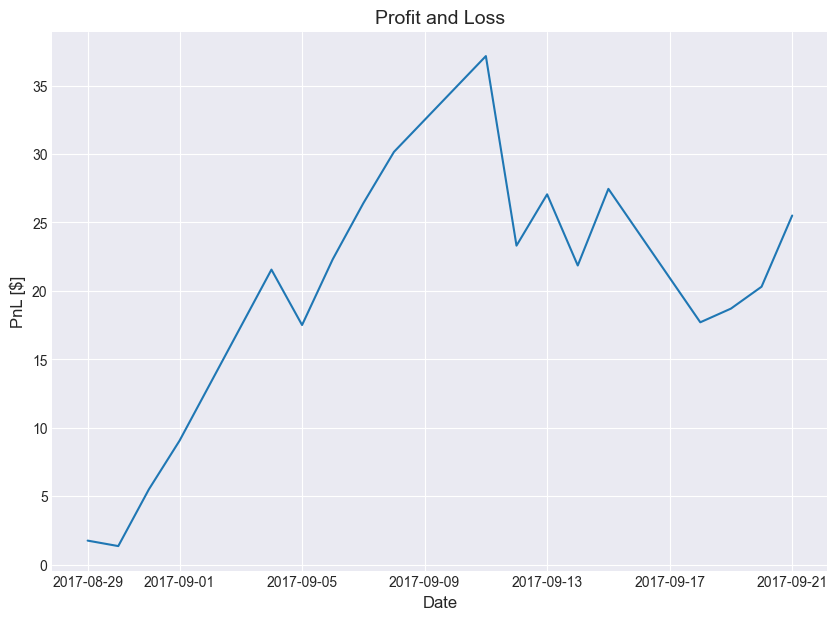

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(nifty_data['pnl'].cumsum())
plt.title('Profit and Loss', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PnL [$]', fontsize=12)
plt.show()

From the above plot, it is clear that our strategy works well and generates a good amount of profit.

## Conclusion
In this notebook, we build a trading strategy using the concept of forward volatility and generated profit from any mispricing of options in the market.<br><br>
